In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import csv
from math import *
import pickle
import itertools

from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

from sklearn.grid_search import GridSearchCV

In [156]:
data = np.loadtxt('data/train.txt', dtype=int, delimiter=',',skiprows=1)
# timestamps = data[:,0]
# data = data[:,1:]
orig_data = np.copy(data)
num_sensors = data.shape[1]-1

In [3]:
def query_data(data, sensor, time_start, time_end):
    # Get starting index and ending index, derived from time_start and time_end
    st_day, en_day = time_start/10000, time_end/10000
    st_hour, en_hour = (time_start%10000)/100, (time_end%10000)/100
    st_min, en_min = time_start%100, time_end%100
    st_index = (st_day-1)*1440 + st_hour*60 + st_min
    en_index = (en_day-1)*1440 + en_hour*60 + en_min
    
    return np.sum(data[st_index:en_index+1,sensor])

#### Get nearest neighbors of each piece

In [4]:
with open('data/sensor-coordinates.txt') as f:
    coords = list()
    reader = csv.reader(f)
    reader.next()
    for row in reader:
        coords.append((float(row[1]), float(row[2])))

In [5]:
def dist(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [6]:
def get_nearest(coords, r=10):
    nearest = list()
    for i in range(56):
        temp = list()
        for j in range(56):
            if i != j:
                if dist(coords[i], coords[j]) < r:
                    temp.append(j+1)
        nearest.append((i+1, tuple(temp)))
    return nearest

In [7]:
n = get_nearest(coords,15)

In [8]:
timestamps = np.unique(data[:,0]%10000)

In [9]:
len(timestamps)

1440

#### Create intervals to sample over

In [10]:
window_size = 20
intervals=[]
for ii in range(0,len(timestamps)-window_size+1,10):
    intervals.append(timestamps[ii:ii+window_size])

The idea is to estimate the distribution for each 20 minute interval (maybe less, 5 or 10 minutes might make more sense) for each sensor. 

From this distribution, you can randomly sample a specified number of times and then take the average of this sample to fill in the missing data. 

After you've filled the missing data you can then take a spatial average (using the nearest neighbors of each sensor that has missing data at that time step), giving the neighbors a higher weighting. 

Do this form of median filtering a couple of times. Check and see...

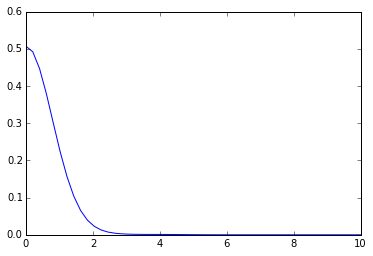

In [150]:
sampled_flow_by_interval = np.zeros(len(intervals),num_sensors)
ival_count = 0
for intval in intervals:
    for i_sens in range(num_sensors):
        sensor = data[:, [0, i+1]]
        sensor = sensor[sensor[:, 1] > -1]
        sensor[:, 0] %= 10000
        X = list()
        for time in intval):
            filtered = sensor[sensor[:, 0] == time]
            if filtered.shape[0] != 0:
                choice = np.random.choice(np.arange(filtered.shape[0]))

                X.append(filtered[:,1])
        X = list(itertools.chain.from_iterable(X))
        
        grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.logspace(-1, 1, 20)},
                    cv=20) # 20-fold cross-validation
        grid.fit(np.array(X).reshape(len(X), 1))
        kde = grid.best_estimator_
        
        # Sample from kde and find expected value
        sampled_entry = np.round(np.mean(np.abs(kde.sample(1000))))
        
        # Place sampled entry into look-up matrix
        sampled_flow_by_interval[ival_count,i_sens] = sampled_entry
        ival_count += 1


In [159]:
np.mean(np.floor(np.abs(kde.sample(100))))

0.02

{'bandwidth': 0.10000000000000001}


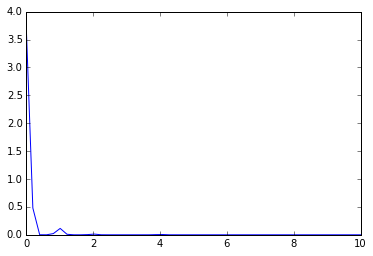

In [151]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.logspace(-1, 1, 20)},
                    cv=20) # 20-fold cross-validation
grid.fit(np.array(X).reshape(len(X), 1))
print grid.best_params_
kde = grid.best_estimator_
plt.plot(np.linspace(0,10), np.exp(kde.score_samples(np.linspace(0,10).reshape(50,1))))

In [157]:
num_sensors

56

In [42]:
cur_time = 1620

In [43]:
sample_intervals = []
for intval in intervals:
    if cur_time in intval:
        sample_intervals.append(intval)

In [44]:
sample_intervals

[array([1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620,
        1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629]),
 array([1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630,
        1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639])]

In [ ]:
KernelDensity()

In [ ]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 10)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print grid.best_params_